$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 3: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

You must **choose one** of the project options specified below.

### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Sentiment Analysis with Self-Attention and Word Embeddings

Based on Tutorials 6 and 7, we'll implement and train an improved sentiment analysis model.
We'll use self-attention instead of RNNs and incorporate pre-trained word embeddings.

In tutorial 6 we saw that we can train word embeddings together with the model.
Although this produces embeddings which are customized to the specific task at hand,
it also greatly increases training time.
A common technique is to use pre-trained word embeddings.
This is essentially a large mapping from words (e.g. in english) to some
high-dimensional vector, such that semantically similar words have an embedding that is
"close" by some metric (e.g. cosine distance).
Use the [GloVe](https://nlp.stanford.edu/projects/glove/) 6B embeddings for this purpose.
You can load these vectors into the weights of an `nn.Embedding` layer.

In tutorial 7 we learned how attention can be used to learn to predict a relative importance
for each element in a sequence, compared to the other elements.
Here, we'll replace the RNN with self-attention only approach similar to Transformer models, roughly based on [this paper](https://www.aclweb.org/anthology/W18-6219.pdf).
After embedding each word in the sentence using the pre-trained word-embedding a positional-encoding vector is added to provide each word in the sentence a unique value based on it's location.
One or more self-attention layers are then applied to the results, to obtain an importance weighting for each word.
Then we classify the sentence based on the average these weighted encodings.


Now, using these approaches, you need to:

- Implement a **baseline** model: Use pre-trained embeddings with an RNN-based model.
You can use LSTM/GRU or bi-directional versions of these, in a way very similar to what we implemented in the tutorial.
-  Implement an **improved** model: Based on the self-attention approach, implement an attention-based sentiment analysis model that has 1-2 self-attention layers instead of an RNN. You should use the same pre-trained word embeddings for this model.
- You can use pytorch's built-in RNNs, attention layers, etc.
- For positional encoding you can use the sinosoidal approach described in the paper (first proposed [here](https://arxiv.org/pdf/1706.03762.pdf)). You can use existing online implementations (even though it's straightforward to implement). 
- You can use the SST database as shown in the tutorial.

Your results should include:
- Everything written in the **Guidelines** above.
- A comparative analysis: compare the baseline to the improved model. Compare in terms of overall classification accuracy and show a multiclass confusion matrix.
- Visualize of the attention maps for a few movie reviews from each class, and explain the results.

In [1]:
# Setup
%matplotlib inline
!pip install torchsummary
from torchsummary import summary

import os
import sys
import time
import torch
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import numpy as np
warnings.simplefilter("ignore")
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Dataset**<br/>
We would like to test a recurrent model over varios datasets.<br/>
We use torchtext package to load SST dataset (3 classes, like recitation and 5 classes, like the paper linked above).<br/>
We decided to use bucket iterator, as presented in the recitation, since it minimize pad tokens and popular in NLP projects.

In [2]:
import torchtext.data
from torchtext.vocab import Vectors, GloVe
import torchtext.datasets
BATCH_SIZE = 32

def load_dataset(name='SST', classes=3):
    review_parser = torchtext.data.Field(
        sequential=True, use_vocab=True, lower=True,
        init_token='<sos>', eos_token='<eos>', dtype=torch.long,
        tokenize='spacy', tokenizer_language='en_core_web_sm')
    # This Field object converts the text labels into numeric values (0,1,2)
    label_parser = torchtext.data.Field(
        is_target=True, sequential=False, unk_token=None, use_vocab=True
    )

    if name=='SST':
        fine_grained = False
        if classes==5:
            fine_grained = True
            
        #3 classes SST
        ds_train, ds_valid, ds_test = torchtext.datasets.SST.splits(
            review_parser, label_parser, root=data_dir,fine_grained=fine_grained)

        print(f'Number of training samples: {len(ds_train)}')
        print(f'Number of test     samples: {len(ds_test)}')
    #build the vocabulary:
    review_parser.build_vocab(ds_train,vectors=GloVe(name='6B', dim=300))
    label_parser.build_vocab(ds_train)
    word_embeddings = review_parser.vocab.vectors
    word_embeddings = word_embeddings.to(device=device)
        
        
    # BucketIterator creates batches with samples of similar length
    # to minimize the number of <pad> tokens in the batch.
    dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,shuffle=True, device=device)
    train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)
    return word_embeddings,train_iter, valid_iter, test_iter

In [3]:
word_embeddings,train_iter, valid_iter, test_iter = load_dataset(name='SST', classes=3)
word_embeddings_5,train_iter_5, valid_iter_5, valid_accur_5 = load_dataset(name='SST', classes=5)

Number of training samples: 8544
Number of test     samples: 2210
Number of training samples: 8544
Number of test     samples: 2210


## Baseline Model:
For the implementation of the sentiment analysis basic model, we used bidirectional GRU,<br/>
the reason we chose it is to avoid the vanishing gradients problem that accure when one might use a simple RNN.<br/>

Lets load the model and show the architecture summary. note that all architectures of network are implemented in the project directory.<br/>
The hyper-parameters were tuned using a grid search in the notebook Hype_Parameters.ipynb (batch size, hidden dim, num of layers and lr).<br/>
Embedding dimension is predefined by GloVe model, the input dimension is dependant of the dataset as well as the output dimension.

In [4]:
batch = next(iter(train_iter))
X, y = batch.text, batch.label
X.shape

torch.Size([53, 32])

In [38]:
from project.RNN import SentimentAnalyzer
from project.Attention import AttentionAnalyzer,MHA as MHAA

VOC_DIM = word_embeddings.shape[0]
EMBEDDING_DIM = 300
HIDDEN_DIM = 16 #
OUTPUT_DIM = 3,5 #5
NUM_LAYERS = 1
#We WILL instantiate two models, one for the fine grained dataset and one for the 3-classes dataset
model3 = SentimentAnalyzer(VOC_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM[0], word_embeddings, layers=NUM_LAYERS,dropout=0.3).to(device)
model5 = SentimentAnalyzer(VOC_DIM, EMBEDDING_DIM, HIDDEN_DIM*2, OUTPUT_DIM[1], word_embeddings_5, layers=NUM_LAYERS*2,dropout=0.3).to(device)

print(f"Baseline model (3-classes):{model3}")

Baseline model (3-classes):SentimentAnalyzer(
  (embd): Embedding(15482, 300)
  (rnn): GRU(300, 16, dropout=0.3, bidirectional=True)
  (sentiment): Linear(in_features=32, out_features=3, bias=True)
  (DO): Dropout(p=0.3, inplace=False)
  (log_softmax): LogSoftmax(dim=1)
)


The model contain pre-trained embedding, bidirectional GRU as RNN, then a FC layer from the hidden dimantion to the output, and a  log softmax layer for logits (so we can use NLLL loss later on).<br/>
We also used Dropout in the GRE and in the FC to avoid some of the overfitting.<br/>

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The Baseline model for SST-3 has {count_parameters(model3):,} trainable weights, and the Baseline model for SST-5 has {count_parameters(model5):,} trainable weights.')

The Baseline model for SST-3 has 30,627 trainable weights, and the Baseline model for SST-5 has 215,685 trainable weights.


Defining the hyperparameters and checkpoints file for the training of the model:

In [7]:
checkpoint_attn ='project/Models/ATTN'
learning_rate = 1e-3,1e-4
batch_size = BATCH_SIZE
hidden_size = HIDDEN_DIM
embedding_length = EMBEDDING_DIM
EPOCHS = 20

In [8]:
from project.Trainer import train_and_eval, present_accuracy,print_stats

***Training the baseline model over the SST-3 dataset***

In [9]:
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate[0])
loss_fn = nn.NLLLoss()
# Train, unless final checkpoint is found
checkpoint = 'project/Models/SST3_RNN_'
checkpoint_file_final = f'{checkpoint}.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} (not training)')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model3.load_state_dict(saved_state['model_state'])
else:
    try: 
        train_accur_base_3, valid_accur_base_3,train_losses_base_3,valid_losses_base_3 = train_and_eval(model3,train_iter, valid_iter, optimizer, loss_fn=loss_fn, epochs=EPOCHS,name='RNN_',data_name = 'SST3')
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')


Epoch #0,train loss=1.062,train accuracy=0.409, validation accuracy=0.417, elapsed=1.7 sec
*** Saved checkpoint project/Models/SST3_RNN_.pt at epoch 1
Epoch #1,train loss=1.062,train accuracy=0.408, validation accuracy=0.438, elapsed=1.6 sec
*** Saved checkpoint project/Models/SST3_RNN_.pt at epoch 2
Epoch #2,train loss=1.060,train accuracy=0.404, validation accuracy=0.529, elapsed=1.7 sec
*** Saved checkpoint project/Models/SST3_RNN_.pt at epoch 3
Epoch #3,train loss=0.980,train accuracy=0.517, validation accuracy=0.649, elapsed=1.6 sec
*** Saved checkpoint project/Models/SST3_RNN_.pt at epoch 4
Epoch #4,train loss=0.860,train accuracy=0.617, validation accuracy=0.645, elapsed=1.7 sec
Epoch #5,train loss=0.820,train accuracy=0.642, validation accuracy=0.653, elapsed=1.6 sec
*** Saved checkpoint project/Models/SST3_RNN_.pt at epoch 6
Epoch #6,train loss=0.796,train accuracy=0.649, validation accuracy=0.655, elapsed=1.6 sec
*** Saved checkpoint project/Models/SST3_RNN_.pt at epoch 7
Epo

Test accuracy: 67.195%


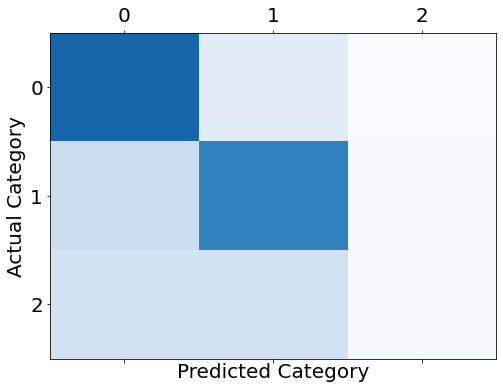

In [10]:
present_accuracy(model3, test_iter,classes=3);

Here we can see the final accuracy, alongside with the confusion matrix <br/><br/>

The model is slightly overfitting, as the trainin accuracy is higher then the test accuracy.<br/>
Alongside with that, the confusion matrix show us that the neutral class have the most mistakes, while for positive and negative the model is pretty accurate, it does not know how to classify the neutral examples.<br/>
This phenomenan is familiar and make sence for two reasons.
First, even for human being it is hard to say when something is nither good of bad.<br/>
Second, the number of the neutral samples is about half as the number of positive and negative, and it's usually happen with imbalanced data.<br/>

to support this claim, we provide some more statistics below, alongside with Precision, Recall and F1 score
and show that the F1 for neutral is extreamly low compare to the rest of the model accuracy.

In [11]:
print_stats(model3, test_iter,classes=3)

              precision    recall  f1-score   support

           0      0.658     0.872     0.750       909
           1      0.693     0.753     0.722       912
           2      0.385     0.013     0.025       389

    accuracy                          0.672      2210
   macro avg      0.578     0.546     0.499      2210
weighted avg      0.624     0.672     0.611      2210



One might change the loss function to optimize over F1 or over the neutral class if it's important.
Since we train a model with no 'real-life' perpuse, we optimize only to achive better accuracy and leave the other options open for other work.

## Training on SST-5:
We will now train the same model on the fine grained SST to see how it performs on a more difficult task

In [40]:
checkpoint = ''#'project/Models/SST5_RNN_'
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate[0])
checkpoint_file_final = f'{checkpoint}.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} (not training)')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model5.load_state_dict(saved_state['model_state'])
else:
    try: 
        train_accur_base_5, valid_accur_base_5,train_losses_base_5,valid_losses_base_5 = train_and_eval(model5,train_iter_5, valid_iter_5, optimizer, loss_fn=loss_fn, epochs=EPOCHS,name='RNN_',data_name = 'SST5')
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

Epoch #0,train loss=1.580,train accuracy=0.262, validation accuracy=0.282, elapsed=2.9 sec
*** Saved checkpoint project/Models/SST5_RNN_.pt at epoch 1
Epoch #1,train loss=1.578,train accuracy=0.266, validation accuracy=0.319, elapsed=2.8 sec
*** Saved checkpoint project/Models/SST5_RNN_.pt at epoch 2
Epoch #2,train loss=1.454,train accuracy=0.342, validation accuracy=0.392, elapsed=2.8 sec
*** Saved checkpoint project/Models/SST5_RNN_.pt at epoch 3
Epoch #3,train loss=1.365,train accuracy=0.389, validation accuracy=0.404, elapsed=2.8 sec
*** Saved checkpoint project/Models/SST5_RNN_.pt at epoch 4
Epoch #4,train loss=1.329,train accuracy=0.402, validation accuracy=0.422, elapsed=2.8 sec
*** Saved checkpoint project/Models/SST5_RNN_.pt at epoch 5
Epoch #5,train loss=1.287,train accuracy=0.420, validation accuracy=0.417, elapsed=2.9 sec
Epoch #6,train loss=1.247,train accuracy=0.438, validation accuracy=0.435, elapsed=2.8 sec
*** Saved checkpoint project/Models/SST5_RNN_.pt at epoch 7
Epo

Test accuracy: 44.977%


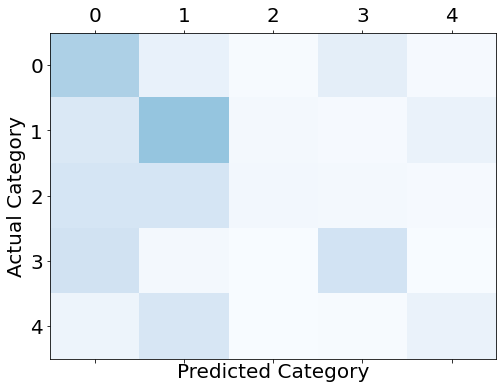

44.97737556561086

In [41]:
present_accuracy(model5, test_iter_5,classes=5)

Here we show the accuracy and confusion matrix as before.<br/><br/>

This is a much harder problem to solve, as we can see from the confusion matrix, the model is the most certain about the positive and negative classes.

We would also show the same statistical attributes as before

In [14]:
print_stats(model5, valid_accur_5,classes=5)

              precision    recall  f1-score   support

           0    0.38622   0.58235   0.46443       510
           1    0.47949   0.59084   0.52937       633
           2    0.43636   0.06170   0.10811       389
           3    0.57108   0.59398   0.58231       399
           4    0.45550   0.31183   0.37021       279

    accuracy                        0.46109      2210
   macro avg    0.46573   0.42814   0.41089      2210
weighted avg    0.46388   0.46109   0.42970      2210



## Self Attention Model
We've tried to overcome this results by using a self attention mechanisem.<br/>

In this work we've implemented both the given paper self attention and a sligthly newer version that we've found that work better for the given problem.<br/>

This model has an attention layer, ontop of the GRU baed rnn, so the representation of each token hidden state is multiply with the Attention head (that in turn, get the rnn output as an input for the Query, Key and Value, thus the name self attention).<br/>

The first implementation based on "Self-Attention-Based BiLSTM Model for Short Text Fine-Grained Sentiment Classification" of xie et el since it achive better results<br/>.

ilustration:
<img src ="Attention"/>

In [15]:
attnModel = AttentionAnalyzer(VOC_DIM, EMBEDDING_DIM, HIDDEN_DIM*2, OUTPUT_DIM[0], word_embeddings, layers=NUM_LAYERS,dropout=0.4).to(device) #attention model for SST3
print(f'The Attention model for 3-classes has {count_parameters(attnModel):,} trainable weights')

The Attention model for 3-classes has 68,548 trainable weights


***Training the model with attention for SST-3***

In [16]:
optimizer = torch.optim.Adam(attnModel.parameters(), lr=learning_rate[0])
loss_fn = nn.NLLLoss()
# Train, unless final checkpoint is found
checkpoint_attn = ''#'project/Models/SST3_Attention_'
checkpoint_file_final = f'{checkpoint_attn}.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} (not training)')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    attnModel.load_state_dict(saved_state['model_state'])
else:
    try:
        train_accur_attn_3, valid_accur_attn_3,train_losses_attn_3,valid_losses_attn_3=\
        train_and_eval(attnModel,train_iter, valid_iter, optimizer, loss_fn=loss_fn, epochs=EPOCHS,name='Attention_',data_name = 'SST3')

    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

Epoch #0,train loss=0.982,train accuracy=0.510, validation accuracy=0.653, elapsed=2.0 sec
*** Saved checkpoint project/Models/SST3_Attention_.pt at epoch 1
Epoch #1,train loss=0.869,train accuracy=0.584, validation accuracy=0.677, elapsed=2.0 sec
*** Saved checkpoint project/Models/SST3_Attention_.pt at epoch 2
Epoch #2,train loss=0.832,train accuracy=0.608, validation accuracy=0.671, elapsed=2.0 sec
Epoch #3,train loss=0.795,train accuracy=0.622, validation accuracy=0.688, elapsed=2.1 sec
*** Saved checkpoint project/Models/SST3_Attention_.pt at epoch 4
Epoch #4,train loss=0.771,train accuracy=0.640, validation accuracy=0.670, elapsed=2.1 sec
Epoch #5,train loss=0.729,train accuracy=0.653, validation accuracy=0.668, elapsed=2.0 sec
Epoch #6,train loss=0.697,train accuracy=0.666, validation accuracy=0.648, elapsed=1.9 sec
Epoch #7,train loss=0.656,train accuracy=0.686, validation accuracy=0.645, elapsed=2.1 sec
Epoch #8,train loss=0.626,train accuracy=0.694, validation accuracy=0.640,

Test accuracy: 69.774%


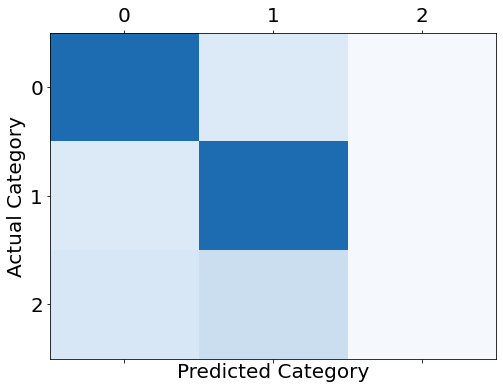

              precision    recall  f1-score   support

           0      0.725     0.845     0.780       909
           1      0.681     0.840     0.752       912
           2      0.308     0.021     0.039       389

    accuracy                          0.698      2210
   macro avg      0.571     0.568     0.524      2210
weighted avg      0.633     0.698     0.638      2210



In [17]:
present_accuracy(attnModel, test_iter,classes=3)
print_stats(attnModel, test_iter,classes=3)

As we can see, this model still strugle with the neutral class, but achive better results in about 2-3 %

In [18]:
attnModel5 = AttentionAnalyzer(VOC_DIM,EMBEDDING_DIM,HIDDEN_DIM*4,OUTPUT_DIM[1],word_embeddings_5,layers=2*NUM_LAYERS,dropout=0.3).to(device)#attention model for SST5
print(f"Attention model:{attnModel5}")
print(f'The Attention model for 5-classes has {count_parameters(attnModel5):,} trainable weights')

Attention model:AttentionAnalyzer(
  (embd): Embedding(15482, 300)
  (rnn): GRU(300, 64, num_layers=2, dropout=0.3, bidirectional=True)
  (W_s1): Linear(in_features=128, out_features=128, bias=True)
  (AttnDrop): Dropout(p=0.3, inplace=False)
  (W_s2): Linear(in_features=128, out_features=1, bias=True)
  (sentiment): Linear(in_features=128, out_features=5, bias=True)
  (DO): Dropout(p=0.3, inplace=False)
  (log_softmax): LogSoftmax(dim=1)
)
The Attention model for 5-classes has 232,326 trainable weights


***Training the attention model for STT-5***

In [19]:
checkpoint_attn ='project/Models/SST5_Attention_'
optimizer = torch.optim.Adam(attnModel5.parameters(), lr=learning_rate[1])
# Train, unless final checkpoint is found
checkpoint_file_final = f'{checkpoint_attn}.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} (not training)')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    attnModel5.load_state_dict(saved_state['model_state'])
else:
    try:
        train_accur_attn_5, valid_accur_attn_5,train_losses_attn_5,valid_losses_attn_5=\
        train_and_eval(attnModel5,train_iter_5, valid_iter_5, optimizer, loss_fn=loss_fn, epochs=EPOCHS,name='Attention_',data_name = 'SST5')

    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

Epoch #0,train loss=1.578,train accuracy=0.268, validation accuracy=0.336, elapsed=3.3 sec
*** Saved checkpoint project/Models/SST5_Attention_.pt at epoch 1
Epoch #1,train loss=1.520,train accuracy=0.319, validation accuracy=0.368, elapsed=3.5 sec
*** Saved checkpoint project/Models/SST5_Attention_.pt at epoch 2
Epoch #2,train loss=1.426,train accuracy=0.369, validation accuracy=0.413, elapsed=4.2 sec
*** Saved checkpoint project/Models/SST5_Attention_.pt at epoch 3
Epoch #3,train loss=1.388,train accuracy=0.381, validation accuracy=0.419, elapsed=4.2 sec
*** Saved checkpoint project/Models/SST5_Attention_.pt at epoch 4
Epoch #4,train loss=1.365,train accuracy=0.401, validation accuracy=0.434, elapsed=4.3 sec
*** Saved checkpoint project/Models/SST5_Attention_.pt at epoch 5
Epoch #5,train loss=1.355,train accuracy=0.400, validation accuracy=0.438, elapsed=4.3 sec
*** Saved checkpoint project/Models/SST5_Attention_.pt at epoch 6
Epoch #6,train loss=1.335,train accuracy=0.407, validation

Test accuracy: 47.149%


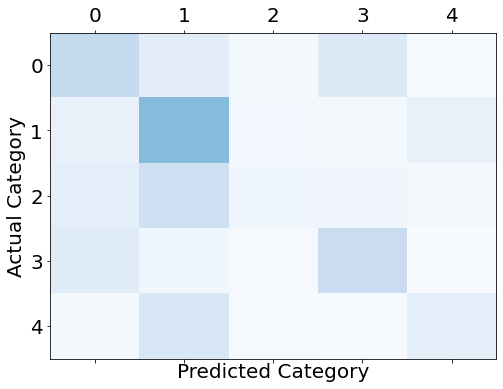

              precision    recall  f1-score   support

           0    0.44484   0.49020   0.46642       510
           1    0.46581   0.68878   0.55577       633
           2    0.36634   0.09512   0.15102       389
           3    0.54524   0.57393   0.55922       399
           4    0.47120   0.32258   0.38298       279

    accuracy                        0.47149      2210
   macro avg    0.45869   0.43412   0.42308      2210
weighted avg    0.45848   0.47149   0.44272      2210



In [20]:
present_accuracy(attnModel5, test_iter_5,classes=5)
print_stats(attnModel5, test_iter_5,classes=5)

## Multi Head Attention
<br/>

Now we would provide a heavier model, that uses N attention heads (we chose 8) that work on the word embeding and Avg the score over them.<br/>
This is the score of all the heads of the sentence, and then we use 2 layers of FC to reduce and make the prediction.<br/>

<img src='Multihead'/>

The Multy Head Attention model for 3-classes has 215,043 trainable weights
Epoch #0,train loss=0.969,train accuracy=0.528, validation accuracy=0.618, elapsed=2.2 sec
*** Saved checkpoint project/Models/SST3_MHA.pt at epoch 1
Epoch #1,train loss=0.817,train accuracy=0.648, validation accuracy=0.652, elapsed=2.2 sec
*** Saved checkpoint project/Models/SST3_MHA.pt at epoch 2
Epoch #2,train loss=0.785,train accuracy=0.664, validation accuracy=0.641, elapsed=2.4 sec
Epoch #3,train loss=0.764,train accuracy=0.671, validation accuracy=0.665, elapsed=2.7 sec
*** Saved checkpoint project/Models/SST3_MHA.pt at epoch 4
Epoch #4,train loss=0.743,train accuracy=0.682, validation accuracy=0.643, elapsed=2.7 sec
Epoch #5,train loss=0.724,train accuracy=0.691, validation accuracy=0.648, elapsed=2.7 sec
Epoch #6,train loss=0.703,train accuracy=0.697, validation accuracy=0.651, elapsed=2.8 sec
Epoch #7,train loss=0.677,train accuracy=0.710, validation accuracy=0.646, elapsed=2.7 sec
Epoch #8,train loss=

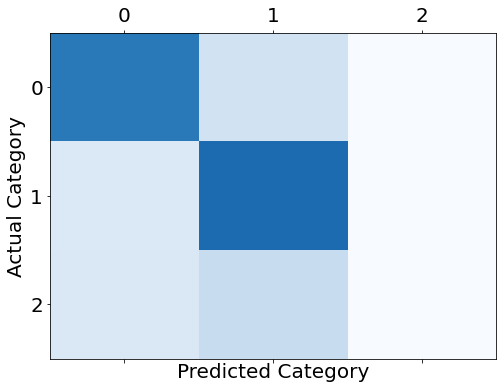

              precision    recall  f1-score   support

           0      0.713     0.788     0.749       909
           1      0.641     0.846     0.729       912
           2      1.000     0.003     0.005       389

    accuracy                          0.674      2210
   macro avg      0.785     0.546     0.494      2210
weighted avg      0.734     0.674     0.610      2210



In [21]:
MHA = MHAA(VOC_DIM, EMBEDDING_DIM, HIDDEN_DIM*4, OUTPUT_DIM[0], word_embeddings, layers=NUM_LAYERS,dropout=0.4).to(device) #attention model for SST3
print(f'The Multy Head Attention model for 3-classes has {count_parameters(MHA):,} trainable weights')
optimizer = torch.optim.Adam(MHA.parameters(), lr=learning_rate[0])
loss_fn = nn.NLLLoss()
train_accur_3, valid_accur_3,train_losses_3,valid_losses_3 = train_and_eval(MHA,train_iter, valid_iter, optimizer, loss_fn=loss_fn, epochs=EPOCHS,name='MHA',data_name = 'SST3');
present_accuracy(MHA, test_iter,classes=3)
print_stats(MHA, test_iter,classes=3)

The Multy Head Attention model for 5-classes has 215,043 trainable weights
Epoch #0,train loss=1.575,train accuracy=0.268, validation accuracy=0.338, elapsed=4.2 sec
*** Saved checkpoint project/Models/SST5_MHA.pt at epoch 1
Epoch #1,train loss=1.428,train accuracy=0.369, validation accuracy=0.392, elapsed=4.3 sec
*** Saved checkpoint project/Models/SST5_MHA.pt at epoch 2
Epoch #2,train loss=1.316,train accuracy=0.422, validation accuracy=0.376, elapsed=4.2 sec
Epoch #3,train loss=1.284,train accuracy=0.436, validation accuracy=0.364, elapsed=4.2 sec
Epoch #4,train loss=1.253,train accuracy=0.451, validation accuracy=0.403, elapsed=4.2 sec
*** Saved checkpoint project/Models/SST5_MHA.pt at epoch 5
Epoch #5,train loss=1.238,train accuracy=0.447, validation accuracy=0.436, elapsed=4.2 sec
*** Saved checkpoint project/Models/SST5_MHA.pt at epoch 6
Epoch #6,train loss=1.216,train accuracy=0.460, validation accuracy=0.426, elapsed=4.2 sec
Epoch #7,train loss=1.208,train accuracy=0.469, vali

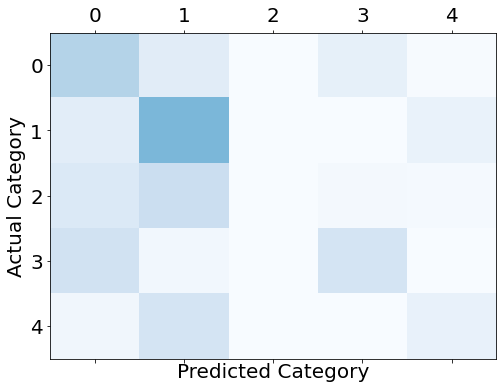

              precision    recall  f1-score   support

           0    0.39640   0.60392   0.47863       510
           1    0.46224   0.72512   0.56458       633
           2    1.00000   0.00514   0.01023       389
           3    0.62681   0.43358   0.51259       399
           4    0.45679   0.26523   0.33560       279

    accuracy                        0.45973      2210
   macro avg    0.58845   0.40660   0.38033      2210
weighted avg    0.57072   0.45973   0.40888      2210



In [43]:
MHA5 = MHAA(VOC_DIM, EMBEDDING_DIM, HIDDEN_DIM*4, OUTPUT_DIM[1], word_embeddings, layers=NUM_LAYERS*2,dropout=0.4).to(device) #attention model for SST3
print(f'The Multy Head Attention model for 5-classes has {count_parameters(MHA):,} trainable weights')
optimizer = torch.optim.Adam(MHA5.parameters(), lr=learning_rate[0])
loss_fn = nn.NLLLoss()
train_accur_5, valid_accur_5,train_losses_5,valid_losses_5 = train_and_eval(MHA5,train_iter_5, valid_iter_5, optimizer, loss_fn=loss_fn, epochs=EPOCHS,name='MHA',data_name = 'SST5');
present_accuracy(MHA5, test_iter_5,classes=5)
print_stats(MHA5, test_iter_5,classes=5)

## Comparing the different models

Now, we would present a comparison of the different models by the diffirent loss and accuracy over the train and test data.

In [52]:
def plot_results(results): #results- list of results from different models, each result is a list
    fig,_ = plt.subplots(nrows=2,ncols=2,sharex=True, figsize = (18,12))
    epochs = [i for i in range(EPOCHS)]
    for i, plot_type in enumerate(('train_acc', 'train_loss', 'valid_acc', 'valid_loss')):
        ax = fig.axes[i]
        models_res = results[plot_type]
        for model in models_res.keys():
            ax.plot(np.array(epochs), models_res[model], label=model)
        ax.set_title(plot_type)
        ax.set_xlabel('epoch')
        ax.legend()
    return fig

## SST-3 Comparison
First, we will compare the performance of different models on SST-3 dataset. 

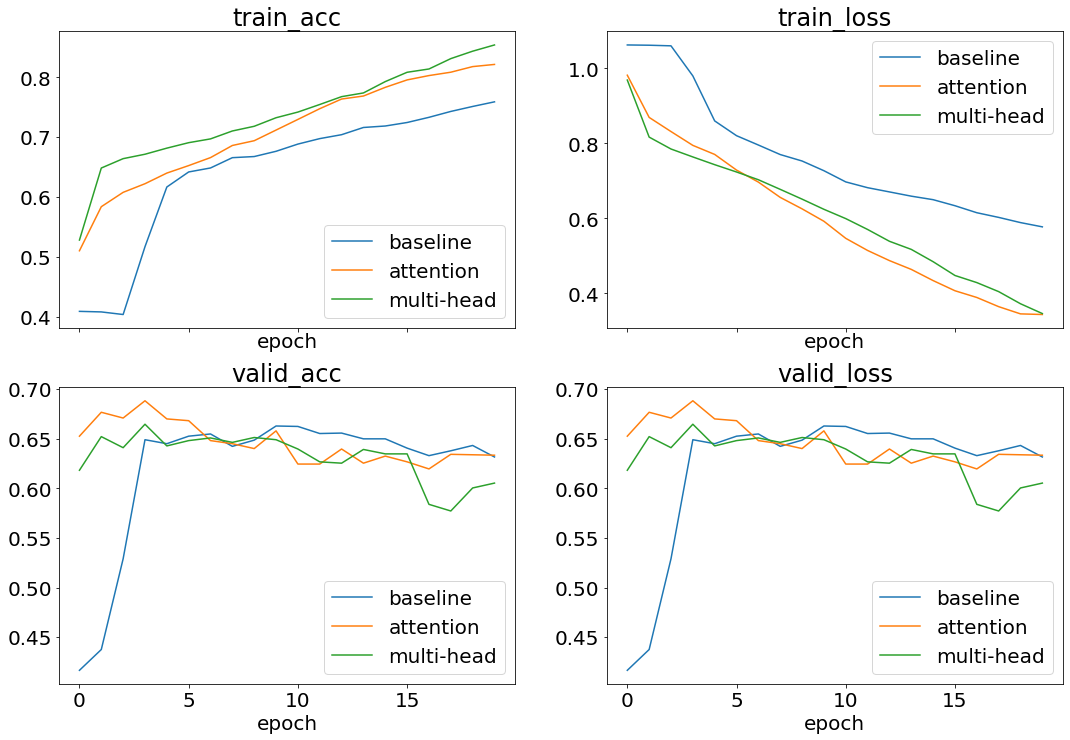

In [53]:
results_3 = {'train_acc':None,'valid_acc':None,'train_loss':None,'valid_loss':None}
results_3['train_acc'] = {'baseline':train_accur_base_3,'attention':train_accur_attn_3,'multi-head':train_accur_3}
results_3['valid_acc'] = {'baseline':valid_accur_base_3,'attention':valid_accur_attn_3,'multi-head':valid_accur_3}
results_3['train_loss'] = {'baseline':train_losses_base_3,'attention':train_losses_attn_3,'multi-head':train_losses_3}
results_3['valid_loss'] = {'baseline':valid_losses_base_3,'attention':valid_losses_attn_3,'multi-head':valid_losses_3}

plot_results(results_3);

First, and foremost, we can see that the attention models (both of the papers implementations) achive better results then the baseline GRU based RNN on the test set.<br/>
the train loss graph shows a good decline, as a loss graph during optimization process should look like.<br/>
note 1: The validation loss graph is mostly for sainity check for us, that there is no data leakage from the train to the validation set and we do not optimize over it.<br/>
note 2: The last validation accuracy is not the highest exist during the training process, we implemented a feature that save the model with most validation accuracy during training.


## SST-5 (Fine Grained) Comparison
Now, we will compare the performance of these models on SST-5

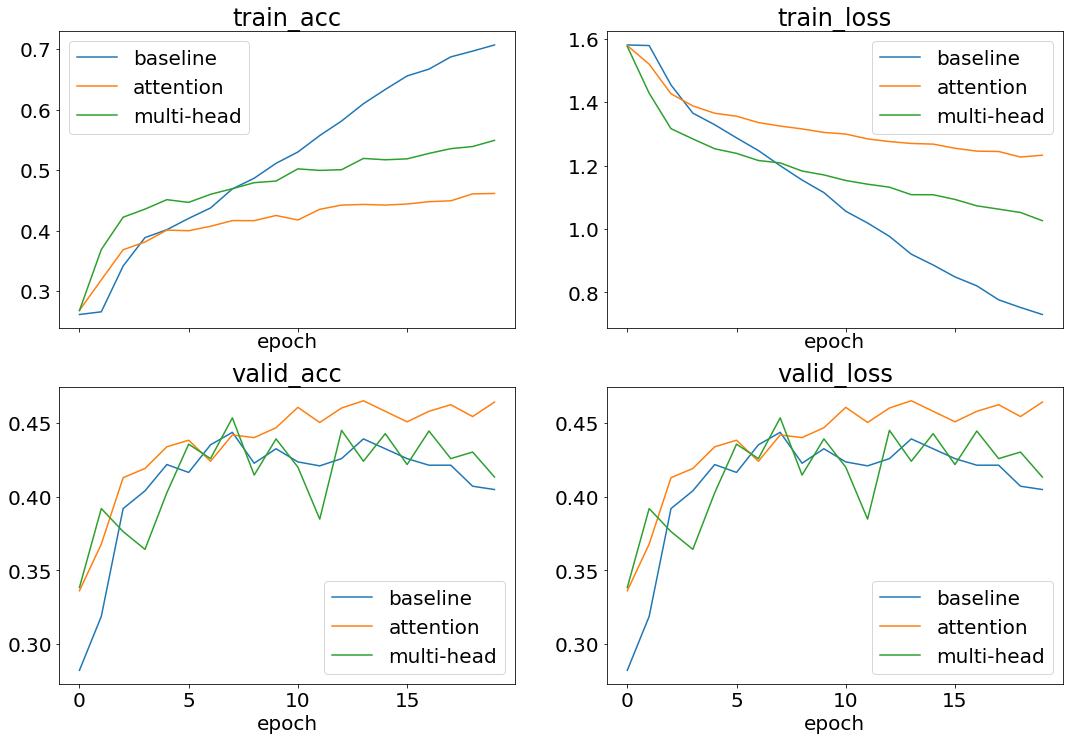

In [56]:
results_5 = {'train_acc':None,'valid_acc':None,'train_loss':None,'valid_loss':None}

results_5['train_acc'] = {'baseline':train_accur_base_5,'attention':train_accur_attn_5,'multi-head':train_accur_5}
results_5['valid_acc'] = {'baseline':valid_accur_base_5,'attention':valid_accur_attn_5,'multi-head':valid_accur_5}
results_5['train_loss'] = {'baseline':train_losses_base_5,'attention':train_losses_attn_5,'multi-head':train_losses_5}
results_5['valid_loss'] = {'baseline':valid_losses_base_5,'attention':valid_losses_attn_5,'multi-head':valid_losses_5}
plot_results(results_5);

Again, we could see that the attention models achieved better accuracy than the baseline model.<br/>
The problem of sentiment analyisis with 5 classes is considered to be hard, therefore the hyper-parameter search made us choose an overfitting model for the baseline architecture.<br/>
note 1: The validation loss graph is mostly for sainity check for us, that there is no data leakage from the train to the validation set and we do not optimize over it.<br/>
note 2: The last validation accuracy is not the highest exist during the training process, we implemented a feature that save the model with most validation accuracy during training.<br/>
note 3: To avoid over fitting for this dataset, we used strong explicit regularization of dropout.